In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import boxcox

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set_style('whitegrid')

In [2]:
file1 = "Loan_known_data.csv"

ChunkSize = 100000
i = 1
for chunk in pd.read_csv(file1, chunksize=ChunkSize):
    df1 = chunk if i == 1 else pd.concat([df1, chunk])
    print('-->Read Chunk...', i)
    i += 1

# data_list = []
# for chunk in pd.read_csv(file2, low_memory=False, chunksize=100000):
#     data_list.append(chunk)
# train_data = pd.concat(data_list)
# del data_list

# create train and test dataset. All laons that are current will be test dataset.

# loan_data.drop(loan_data.columns[0], axis=1, inplace = True)

-->Read Chunk... 1
-->Read Chunk... 2
-->Read Chunk... 3
-->Read Chunk... 4
-->Read Chunk... 5
-->Read Chunk... 6
-->Read Chunk... 7
-->Read Chunk... 8
-->Read Chunk... 9
-->Read Chunk... 10
-->Read Chunk... 11


In [3]:
df1.shape

(1085612, 35)

In [4]:
df1.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs',
       'initial_list_status', 'open_acc_6m', 'open_act_il', 'open_il_12m',
       'il_util', 'open_rv_12m', 'inq_fi', 'inq_last_12m',
       'acc_open_past_24mths', 'mort_acc', 'num_accts_ever_120_pd',
       'num_tl_op_past_12m', 'tot_hi_cred_lim', 'total_bal_ex_mort',
       'total_bc_limit', 'year', 'percent_complete', 'max_bal_bc_cat',
       'num_sats_cat', 'percent_bc_gt_75_cat'],
      dtype='object')

In [5]:
df_LC = df1.filter(['loan_amnt','term','int_rate','installment','grade','emp_length','home_ownership',
                    'annual_inc','verification_status','purpose','dti','delinq_2yrs','loan_status'])
df_LC.dtypes

loan_amnt                int64
term                    object
int_rate               float64
installment            float64
grade                   object
emp_length               int64
home_ownership          object
annual_inc             float64
verification_status     object
purpose                 object
dti                    float64
delinq_2yrs            float64
loan_status             object
dtype: object

### Finding the correlation between variables ###
We will now look at the correlation structure between our variables that we selected above. This will tell us about any dependencies between different variables and help us reduce the dimensionality a little bit more

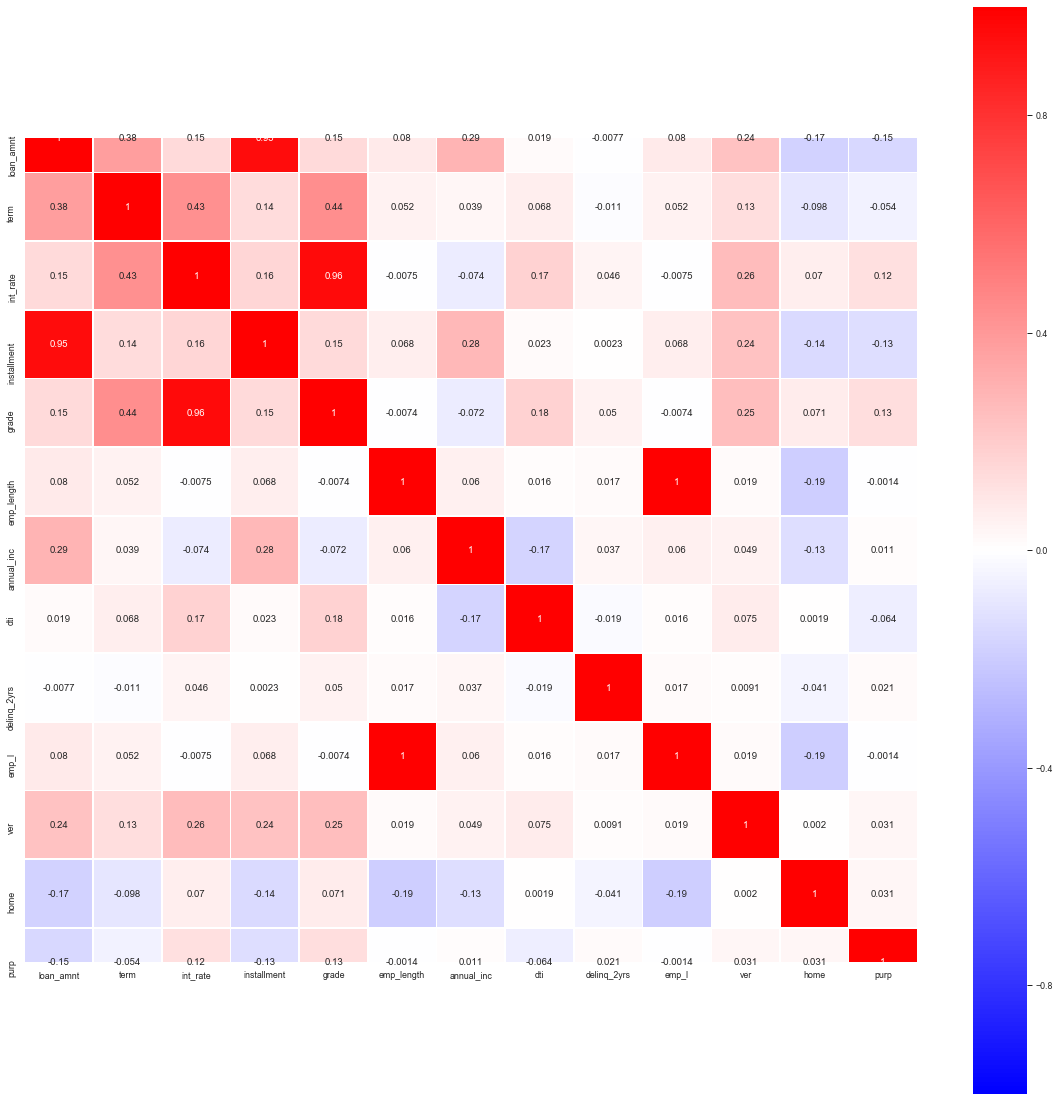

In [6]:
plt.figure(figsize=(20,20))
sns.set_context("paper", font_scale=1)
##finding the correllation matrix and changing the categorical data to category for the plot.
sns.heatmap(df_LC.assign(grade=df_LC.grade.astype('category').cat.codes,
                         term=df_LC.term.astype('category').cat.codes,
                        emp_l=df_LC.emp_length.astype('category').cat.codes,
                         ver =df_LC.verification_status.astype('category').cat.codes,
                        home=df_LC.home_ownership.astype('category').cat.codes,
                        purp=df_LC.purpose.astype('category').cat.codes).corr(), 
                         annot=True, cmap='bwr',vmin=-1, vmax=1, square=True, linewidths=0.5)

In [7]:
df1.delinq_2yrs.value_counts()

0.0     869909
1.0     142728
2.0      42273
3.0      15492
4.0       6821
5.0       3522
6.0       1925
7.0       1069
8.0        628
9.0        395
10.0       277
11.0       166
12.0       123
13.0        78
14.0        69
15.0        42
16.0        27
18.0        19
17.0        12
19.0        11
20.0         9
21.0         5
29.0         2
22.0         2
25.0         2
24.0         1
26.0         1
39.0         1
36.0         1
27.0         1
30.0         1
Name: delinq_2yrs, dtype: int64

We will now encode the two categories listed above as 0 or 1 for our analysis. This will help us in predicting whether a person defaulted their loan or not. 0 means he deaulted and 1 means he paid off his loan.

In [8]:
df_LC.loan_status=df_LC.loan_status.astype('category').cat.codes
df_LC.delinq_2yrs=df_LC.delinq_2yrs.astype('category').cat.codes
df_LC.head()
df_LC['loan_status'].value_counts()

1    851566
0    234046
Name: loan_status, dtype: int64

It can be seen from the plot above that loan amount and installment have a very high correlation amongst each other (0.94). This is intuitive since a person who takes a large sum of loan would require extra time to repay it back. Also, interest rate, sub grade and grade have a very high correlation between them. This is obvious since interest rate is decided by grades once the grades are decided, a subgrade is assigned to that loan (leading to high correlation).

Let's drop the three categories alongwith term and verification status(since it doesn't provide any valuable info) for further analysis.

In [9]:
df_LC.drop(['installment','grade','verification_status','term']
           , axis=1, inplace = True)

### Transformation###
Before training the data, we would first transform the data to account for any skewness in the variable distribution. Various transformation techniques ranging from log transform to power transformation are available. For our analysis, we'll be using Box-cox transformation. It is used to modify the distributional shape of a set of data to be more normally distributed so that tests and confidence limits that require normality can be appropriately used.

In [10]:
numerical = df_LC.columns[df_LC.dtypes == 'float64']
for i in numerical:
    if df_LC[i].min() > 0:
        transformed, lamb = boxcox(df_LC.loc[df_LC[i].notnull(), i])
        if np.abs(1 - lamb) > 0.02:
            df_LC.loc[df_LC[i].notnull(), i] = transformed

In [11]:
df_LC.head()

,loan_amnt,int_rate,emp_length,home_ownership,annual_inc,purpose,dti,delinq_2yrs,loan_status
0,30000,4.281026,5,MORTGAGE,5.773601,debt_consolidation,30.46,0,1
1,40000,3.700528,0,MORTGAGE,5.600723,credit_card,50.53,0,1
2,20000,2.483712,10,MORTGAGE,5.773601,credit_card,18.92,0,1
3,4500,3.107390,10,RENT,5.564671,credit_card,4.64,0,1
4,8425,4.654540,3,MORTGAGE,6.051845,credit_card,12.37,0,1


In [12]:
df_LC.purpose.value_counts()

debt_consolidation    640222
credit_card           239225
home_improvement       69325
other                  59852
major_purchase         22372
medical                12077
small_business         10616
car                    10468
moving                  7355
vacation                7000
house                   5645
wedding                  781
renewable_energy         673
educational                1
Name: purpose, dtype: int64

In [13]:
df_LC.purpose.unique()

array(['debt_consolidation', 'credit_card', 'other', 'house', 'car',
       'home_improvement', 'moving', 'medical', 'major_purchase',
       'vacation', 'small_business', 'renewable_energy', 'wedding',
       'educational'], dtype=object)

In [14]:
# df_clean2["loan_status"].map(loan_status_dict)

# df_LC['purpose'] = df_LC[~df_LC.purpose.isin(['debt_consolidation', 'credit_card', 'home_improvement', 'major_purchase', 'medical',\
#                         'small_business', 'car'])].replace('other')


In [15]:


purpose_dict = {'debt_consolidation': 'debt_consolidation', 'credit_card': 'credit_card', 'house' : 'home_improvement' ,\
                'car' : 'major_purchase', 'other': 'other',  'moving' : 'other', 'vacation' : 'other',\
                'small_business' : 'other', 'renewable_energy' : 'other', 'wedding' : 'other', 'educational' : 'other', \
               'home_improvement':'home_improvement', 'medical': 'medical', 'major_purchase':'major_purchase', }


In [16]:
df_LC['purpose'] = df_LC['purpose'].map(purpose_dict)
# df_LC['purpose'].map(purpose_dict)

In [17]:
df_LC.purpose.unique()

array(['debt_consolidation', 'credit_card', 'other', 'home_improvement',
       'major_purchase', 'medical'], dtype=object)

### One Hot Encoding ###
Since we have some categorical variables for the analysis and the machne learning algorithms doesn't take categorical and string variables directly, we have to creat dummy variables for them. We can either encode them using label encoder available for python, but it would be wrong in our analysis since a lot of these variables have multiple categories. Just using weights can cause discrepencies in the algorithm. Instead, we will one hot encode these so that we have a 1 wherever that category turns up and 0 otherwise. This will also create seperate columns for each level of category. Also, we'll be dropping one of the categories so that we have N-1 columns instead of N.

In [18]:
df_LC = pd.get_dummies(df_LC, drop_first=True)

In [19]:
df_LC.head()

,loan_amnt,int_rate,emp_length,annual_inc,dti,delinq_2yrs,loan_status,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_medical,purpose_other
0,30000,4.281026,5,5.773601,30.46,0,1,1,0,0,0,0,1,0,0,0,0
1,40000,3.700528,0,5.600723,50.53,0,1,1,0,0,0,0,0,0,0,0,0
2,20000,2.483712,10,5.773601,18.92,0,1,1,0,0,0,0,0,0,0,0,0
3,4500,3.107390,10,5.564671,4.64,0,1,0,0,0,0,1,0,0,0,0,0
4,8425,4.654540,3,6.051845,12.37,0,1,1,0,0,0,0,0,0,0,0,0


Now splitting the data using scikitlearn's train_test_split and using 60% data for training and 40% for testing.

In [20]:
traindata, testdata = train_test_split(df_LC, stratify=df_LC['loan_status'],test_size=.4, random_state=17)
testdata.reset_index(drop=True, inplace=True)
traindata.reset_index(drop=True, inplace=True)

We'll now scale the data so that each column has a mean of zero and unit standard deviation. Xunb (unbalanced set) and yunb are the independent and target variable.

In [21]:
sc = StandardScaler()
Xunb = traindata.drop('loan_status', axis=1)
yunb = traindata['loan_status']
numerical = Xunb.columns[(Xunb.dtypes == 'float64') | (Xunb.dtypes == 'int64')].tolist()
Xunb[numerical] = sc.fit_transform(Xunb[numerical])

In [22]:
yunb.shape

(651367,)

### Model Selection ###
We are now ready to build some models. The following would be our approach for building and selecting the best model:

* Build a model on the imbalance dataset we got from data cleaning.
* Balance the dataset by using equal amount of default and 'fully paid' loans.
#### Trying the Unbalanced Dataset ####
Let's first try the unbalanced dataset.The function below computes the receiver operating characteristic (ROC) curves for each of the models. This function will be called later in the analysis.

In [23]:
def createROC(models, X, y, Xte, yte):
    false_p, true_p = [], [] ##false postives and true positives

    for i in models.keys():  ##dict of models
        models[i].fit(X, y)

        fp, tp, threshold = roc_curve(yte, models[i].predict_proba(Xte)[:,1]) ##roc_curve function

        true_p.append(tp)
        false_p.append(fp)
    return true_p, false_p ##returning the true postive and false positive

Let's try some models on the train dataset With 3 fold cross validation. We are going to use the following 4 machine learning algorithms:

* Linear Discriminant Analysis
* Multinomial Naive Bayes
* Random Forest (tree based model)
* Logistic Regression

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

models = {'LDA': LinearDiscriminantAnalysis(),
          'MNB': MultinomialNB(),
          'RF': RandomForestClassifier(n_estimators=100),
          'LR': LogisticRegression(C=1, solver='lbfgs')}

unbalset = {}
for i in models.keys():
    scores = cross_val_score(models[i], Xunb - np.min(Xunb) + 1,
                                    yunb, cv=3)
    unbalset[i] = scores
    print(i, scores, np.mean(scores))

LDA [0.78559158 0.78583469 0.7861617 ] 0.7858626554171124
MNB [0.78435265 0.78437929 0.78440232] 0.7843780848975107
RF [0.77909296 0.77870045 0.77909194] 0.7789617832478876


C:\Users\Rishbha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Rishbha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LR [0.78589095 0.78591759 0.7860834 ] 0.7859639804795666


C:\Users\Rishbha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Looks like Logistic regression provides the best estimate and almost all of the models giving the same results. Because of the issue of collinearity in LDA, we are going to ignore that.

Now creating the test set for the analysis and scaling it.

In [25]:
Xte = testdata.drop('loan_status', axis=1)
yte = testdata['loan_status']
numerical = Xte.columns[(Xte.dtypes == 'float64') | (Xte.dtypes == 'int64')].tolist()
Xte[numerical] = sc.fit_transform(Xte[numerical])

Computing the ROC curves for the models and finding the true positive and false positives.

In [26]:
tp_unbalset, fp_unbalset = createROC(models, Xunb - np.min(Xunb) + 1, yunb, Xte - np.min(Xte) + 1, yte)

C:\Users\Rishbha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fitting LR to the test set.

In [27]:
model =  LogisticRegression(C=1, solver='lbfgs')
model.fit(Xunb, yunb)
predict = model.predict(Xte) #prediction of Xte which can be used to test against yte (testdata values or true values of y)

In [28]:
m = yte.to_frame()
m['loan_status'].value_counts()

1    340627
0     93618
Name: loan_status, dtype: int64

We will now plot the cross-validation scores, ROC curves and confusion matrix of random forest model. X axis is the true value and Y axis is the predicted value.

C:\Users\Rishbha\Anaconda3\lib\site-packages\seaborn\matrix.py:318: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  ax.figure.draw(ax.figure.canvas.get_renderer())


(0.0, 2.0, 2.0, 0.0)

C:\Users\Rishbha\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Rishbha\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


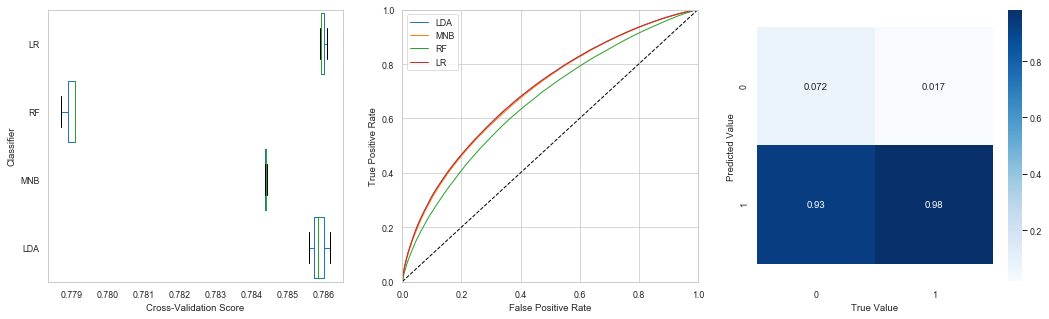

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

ax = pd.DataFrame(unbalset).boxplot(widths=(0.9,0.9,0.9,0.9), grid=False, vert=False, ax=axes[0])
ax.set_ylabel('Classifier')
ax.set_xlabel('Cross-Validation Score')

for i in range(0, len(tp_unbalset)):
    axes[1].plot(fp_unbalset[i], tp_unbalset[i], lw=1)

axes[1].plot([0, 1], [0, 1], '--k', lw=1)
axes[1].legend(models.keys())
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_xlim(0,1)
axes[1].set_ylim(0,1)

cm = confusion_matrix(yte, predict).T
cm = cm.astype('float')/cm.sum(axis=0)

ax = sns.heatmap(cm, annot=True, cmap='Blues', ax=axes[2]);
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')
ax.axis('equal')

The cross-validation scores and ROC curves suggest the Logistic Regression is the best model, though the MNB and linear discriminant analysis models are pretty close behind. If we look at the confusion matrix, though, we see a big problem.The model can predict who are going to pay off the loan with a good accuracy of 99% but cannot predict who are going to default. The true positive rate of default (0 predicting 0) is almost 0. Since our main goal is to predict defaulter's, we have to do something about this.

The reason this is happening could be because of high imbalance in our dataset and the algorithm is putting everything into 1. We have to chose a new prediction threshold according to the sensitivity and specificity of the model. This will create some balance in predicting the binary outcome. Let's look at the plots below.

In [30]:
fp, tp, threshold = roc_curve(yte, model.predict_proba(Xte)[:,1]) 

Text(0, 0.5, 'True Positive & False Positive Rates')

C:\Users\Rishbha\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Rishbha\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


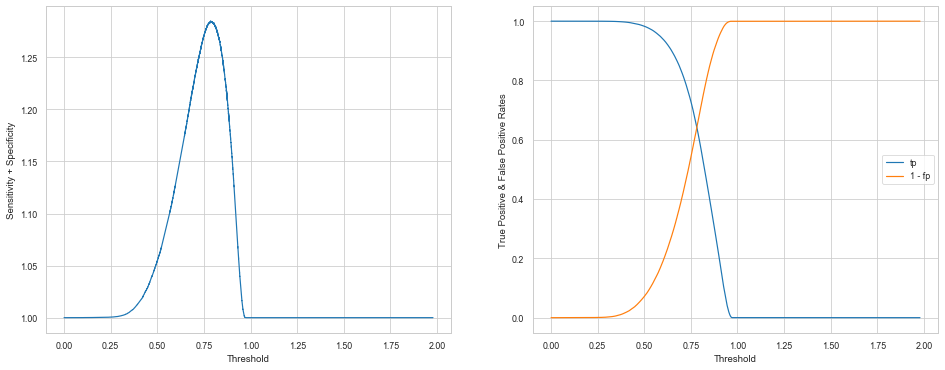

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax[0].plot(threshold, tp + (1 - fp))
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('Sensitivity + Specificity')

ax[1].plot(threshold, tp, label="tp")
ax[1].plot(threshold, 1 - fp, label="1 - fp")
ax[1].legend()
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('True Positive & False Positive Rates')

In [32]:
##finding the optimal threshold for the model 
function = tp + (1 - fp)
index = np.argmax(function)

optimal_threshold = threshold[np.argmax(function)]
print('optimal threshold:', optimal_threshold)

optimal threshold: 0.7869873998178931


The optimal threshold above is where the the two graphs meet.

* Sensitivity (also called the true positive rate, the recall, or probability of detection in some fields) measures the proportion of actual positives that are correctly identified as such (e.g., the percentage of sick people who are correctly identified as having the condition).

* Specificity (also called the true negative rate) measures the proportion of actual negatives that are correctly identified as such (e.g., the percentage of healthy people who are correctly identified as not having the condition)

Now using this threshold for the model:

(0.0, 2.0, 2.0, 0.0)

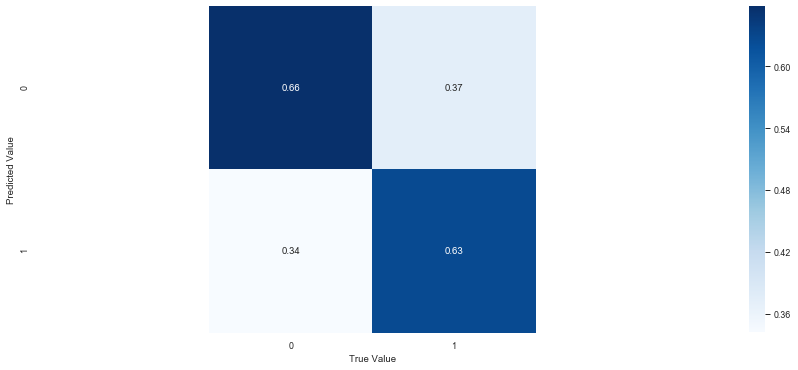

In [33]:
predict = model.predict_proba(Xte)[:,1]
predict = np.where(predict >= optimal_threshold, 1, 0)

fig, axes = plt.subplots(figsize=(15,6))

cm = confusion_matrix(yte, predict).T
cm = cm.astype('float')/cm.sum(axis=0)

ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')
ax.axis('equal')

In [47]:
from sklearn.neighbors import KNeighborsClassifier

sc = StandardScaler()
X_train = traindata.drop('loan_status', axis=1)
y_train = traindata['loan_status']
numerical = Xunb.columns[(Xunb.dtypes == 'float64') | (Xunb.dtypes == 'int64')].to_numpy()
X_train[numerical] = sc.fit_transform(Xunb[numerical])
# X_train = Xunb - np.min(Xunb) + 1

X_test = testdata.drop('loan_status', axis=1)
y_test = testdata['loan_status']
numerical = X_test.columns[(X_test.dtypes == 'float64') | (X_test.dtypes == 'int64')].to_numpy()
X_test[numerical] = sc.fit_transform(X_test[numerical])
# X_test = testdata.drop('loan_status', axis=1)
# y_test = testdata['loan_status']

# neighbors = np.arange(10, 25)
# train_accuracy = np.empty(len(neighbors))
# test_accuracy = np.empty(len(neighbors))

# for i, n in enumerate(neighbors):
#     knn = KNeighborsClassifier(n_neighbors=n)
#     knn.fit(X_train, y_train)
#     train_accuracy[i] = knn.score(X_train, y_train)
#     test_accuracy[i] = knn.score(X_test, y_test)

# plt.title('k-NN: Varying Number of Neighbors')
# plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
# plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
# plt.legend()
# plt.xlabel('Number of Neighbors')
# plt.ylabel('Accuracy')
# plt.show()
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In [51]:
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
train_accuracy = np.empty(len(c_space))
test_accuracy = np.empty(len(c_space))
for i, c in enumerate(c_space):
    print(i)
    logreg = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000, C = c)
    logreg.fit(X_train, y_train)
    train_accuracy[i] = logreg.score(X_train, y_train)
    test_accuracy[i] = logreg.score(X_test, y_test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


[0.21558797 0.21558797 0.21558797 0.21558797 0.21558797 0.21558797
 0.21558797 0.21558797 0.21558797 0.21558797 0.21558797 0.21558797
 0.21558797 0.21558797 0.21558797]
[0.63809343 0.63886872 0.63890249 0.6388288  0.63900535 0.63893473
 0.63897772 0.63901149 0.63898847 0.63895776 0.63893934 0.63900996
 0.63898079 0.6389854  0.63899768]


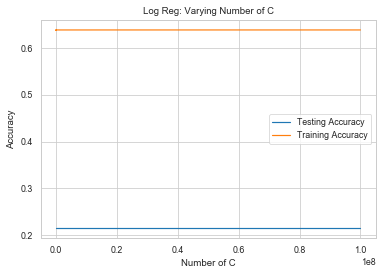

In [52]:
print(test_accuracy)
print(train_accuracy)
plt.title('Log Reg: Varying Number of C')
plt.plot(c_space, test_accuracy, label = 'Testing Accuracy')
plt.plot(c_space, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of C')
plt.ylabel('Accuracy')
plt.show()

In [53]:
def print_report(test_y, test_predict):
    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(test_y, test_predict))

    from sklearn.metrics import classification_report
    print(classification_report(test_y, test_predict))

In [73]:

y = df_LC['loan_status']
X = df_LC.drop('loan_status', axis=1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 42) 

In [74]:
from sklearn.linear_model import LogisticRegression

print('Fitting logistic regression model...')
log_reg = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train)

print('\nResults on train:')
print_report(y_train, log_reg.predict(X_train))

print('\nResults on test:')
print_report(y_test, log_reg.predict(X_test))

Fitting logistic regression model...

Results on train:
[[ 91945  48841]
 [185988 324593]]
              precision    recall  f1-score   support

           0       0.33      0.65      0.44    140786
           1       0.87      0.64      0.73    510581

    accuracy                           0.64    651367
   macro avg       0.60      0.64      0.59    651367
weighted avg       0.75      0.64      0.67    651367


Results on test:
[[ 60354  32906]
 [124118 216867]]
              precision    recall  f1-score   support

           0       0.33      0.65      0.43     93260
           1       0.87      0.64      0.73    340985

    accuracy                           0.64    434245
   macro avg       0.60      0.64      0.58    434245
weighted avg       0.75      0.64      0.67    434245




That's great! The optimum threshold for the classifier have increased out models prediction power of Default (0). Even now the model doesn't provide a lot of prediction power and we have to train the model again using a different algorithm with some tweaks.

### Part2 : Balancing the training dataset and creating a new model ###

Now we will try to use a balanced dataset with equal amount of zeroes and 1's. The following part does the same.

In [34]:
y_default = traindata[traindata['loan_status'] == 0]
n_paid = traindata[traindata['loan_status'] == 1].sample(n=len(y_default), random_state=17) ##chosing equal amount of 1's

##creating a new dataframe for balanced set
data = y_default.append(n_paid) 

##creating the independent and dependent array
Xbal = data.drop('loan_status', axis=1)
ybal = data['loan_status']

In [35]:
## scaling it again
numerical = Xbal.columns[(Xbal.dtypes == 'float64') | (Xbal.dtypes == 'int64')].tolist()
Xbal[numerical] = sc.fit_transform(Xbal[numerical])

Training the model on the balanced set

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

models = {'LDA': LinearDiscriminantAnalysis(),
          'MNB': MultinomialNB(),
          'RF': RandomForestClassifier(n_estimators=100),
          'LR': LogisticRegression(C=1, solver='lbfgs')}

balset = {}
for i in models.keys():
    scores = cross_val_score(models[i], Xbal - np.min(Xbal) + 1,
                                    ybal, scoring='roc_auc', cv=3)
    balset[i] = scores
    print(i, scores, np.mean(scores))

LDA [0.69747885 0.69943139 0.6969639 ] 0.6979580453210351
MNB [0.69394694 0.69588793 0.69272156] 0.6941854789355721
RF [0.67983785 0.68167087 0.68024806] 0.6805855928981327
LR [0.69764274 0.69953985 0.69721007] 0.698130884799049


Even though we almost got the same result as before, This time we are going to select Random Forst method and will try to find the optimal number of trees using the gridsearchcv and try to make the predition based on this and lets see if there is any improvements in predicting 0's

In [37]:
model = RandomForestClassifier(n_estimators=100)
model.fit(Xbal, ybal)
predict = model.predict(Xte)

(0.0, 2.0, 2.0, 0.0)

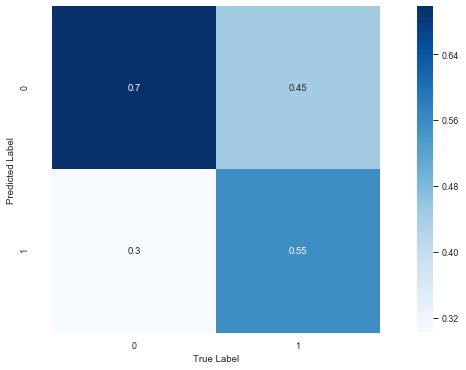

In [38]:
predict = model.predict(Xte)
fig, axes = plt.subplots(figsize=(8,6))
cm = confusion_matrix(yte, predict).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.axis('equal')



That's a significant improvement over the last model that we built using Logistic regression.

Let's find the optimum number of estimators for this model and use that for prediction. This time we are going to use 5 fold cross validation.

In [40]:
params = {'n_estimators': [50, 100, 200, 400, 600, 800]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=params,
                                   scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(Xbal, ybal)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'n_estimators': 800}
0.6348520238129148


The best model has 800 trees

In [41]:
grid_search.best_estimator_.fit(Xbal, ybal)
predict = model.predict(Xte)

(0.0, 2.0, 2.0, 0.0)

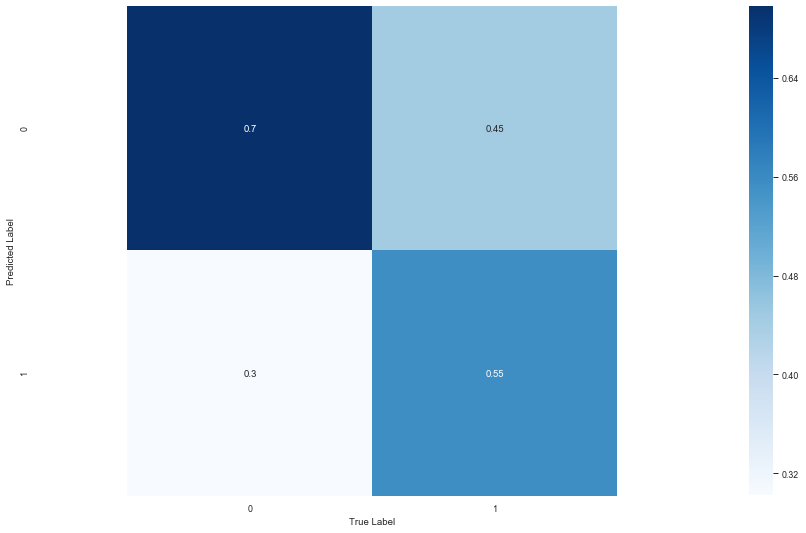

In [42]:
fig, axes = plt.subplots(figsize=(15,9))
cm = confusion_matrix(yte, predict).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.axis('equal')

Interestingly, this gives us the same output as the previous model. Even now we have a good accuracy of 71% predicting defaluter's as defaulter's.

Since random forest is based on decision trees, we can also plot the variable importance. Variable importance tells us which variable had highest importance when predicting an outcome.

Text(0, 0.5, 'Relative Importance')

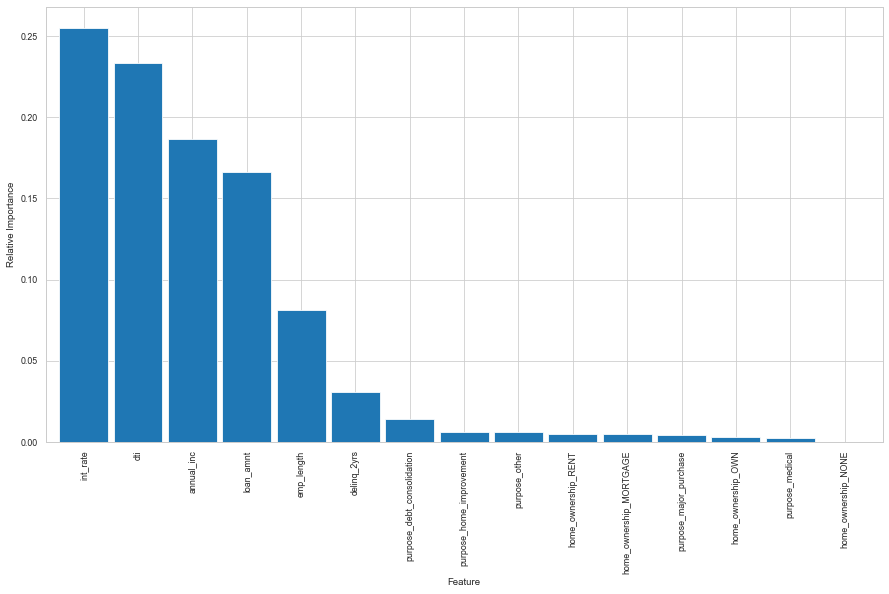

In [43]:
r = pd.DataFrame(columns=['Feature','Importance'])
ncomp = 15
r['Feature'] = feat_labels = Xbal.columns
r['Importance'] = model.feature_importances_
r.set_index(r['Feature'], inplace=True)
ax = r.sort_values('Importance', ascending=False)[:ncomp].plot.bar(width=0.9, legend=False, figsize=(15,8))
ax.set_ylabel('Relative Importance')

As you can see, interest rate followed by debt to income ratio,annual income, and loan amount are the most important features in predicting the defaulter's. Lending Club might want to use this as the metric for identifying people defaulting on their loans.

### Conclusion
We have successfully built an machine learning algorithm to predict the people who might default on their loans. This can be further used by LendingClub for their analysis. Also, we might want to look on other techniques or variables to improve the prediction power of the algorthm. One of the drawbacks is just the limited number of people who defaulted on their loan in the 8 years of data (2007-2015) present on the dataset. We can use an updated dataframe which consist next 3 years values (2015-2018) and see how many of the current loans were paid off or defaulted or even charged off. Then these new data points can be used for predicting them or even used to train the model again to improve its accuracy.

Since we had a lot of categorical data, we cannot apply PCA for dimensionality reduction. Because of this, we can try some different type of variable selection method like 'MULTIPLE CORRESPONDENCE ANALYSIS' to reduce the dimensionality and select the most important variables from the columns.

Since the algorithm puts around 47% of non-defaulters in the default class, we might want to look further into this issue to make the model more robust.